# Steady Laminar Flamelet Model
Flamelet assumptions:
\begin{equation}
    \phi = \phi(Z; \chi_\mathrm{st})
\end{equation}
To get the Favre-averaged or filtered value:
\begin{equation}
    \widetilde{\phi} = \iint \phi(Z; \chi_\mathrm{st}) \widetilde{f}(Z, \chi_\mathrm{st}) dZd\chi_\mathrm{st}
\end{equation}
With the assumptions of independence between $Z$ and $\chi_\mathrm{st}$ distributions
\begin{equation}
    \widetilde{\phi} = \iint \phi(Z; \chi_\mathrm{st}) \widetilde{f}(Z)\widetilde{f}(\chi_\mathrm{st}) dZd\chi_\mathrm{st}
\end{equation}
Assuming $\beta$ distribution for $Z$ and delta distribution for $\chi_\mathrm{st}$
\begin{equation}
    \widetilde{\phi} (\tilde{Z}, \widetilde{Z^{''2}}; \chi_\mathrm{st}) = \int \phi(Z; \chi_\mathrm{st}) \widetilde{f}(Z; \tilde{Z}, \widetilde{Z^{''2}}) dZ
\end{equation}

In [13]:
import os
import glob
import numpy as np
import h5py
from beta_integration import beta_integration
import matplotlib.pyplot as plt

In [2]:
# get the flamelet solutions
dir_name = 'flamelets'
file_suffix = 'csv'

chi = []
os.chdir(dir_name)
for filename in glob.glob('.'.join(['*', file_suffix])):
    chi.append(float(filename[:-4]))
os.chdir('..')
chi.sort()
chi = np.array(chi)
n_chi = chi.size

In [3]:
# take the flamelet solution with largest chi_st
filename = '{0}/{1:g}.{2}'.format(dir_name, chi[-1], file_suffix)
flamelet = np.genfromtxt(filename, names=True, delimiter=',')

In [4]:
# the Z_average axis
Z_average = flamelet['Z']
n_Z_average = Z_average.size

In [31]:
# the number of variables to be integrated
names = list(flamelet.dtype.names)
names.remove('Z')
variable_names = np.array( names )
n_variable = variable_names.size

In [6]:
# the Z_variance axis
n_Z_variance = 20
Z_variance = np.linspace(0., 1., num=n_Z_variance)

In [7]:
flamelet_table = np.empty((n_chi, n_Z_variance, n_Z_average, n_variable))

In [8]:
for l, chi_st in enumerate(chi):
    filename = '{0}/{1:g}.{2}'.format(dir_name, chi_st, file_suffix)
    flamelet = np.genfromtxt(filename, names=True, delimiter=',')    
    for i, nvar in enumerate(Z_variance):
        for j, ave in enumerate(Z_average):
            for k, name in enumerate(variable_names):
                flamelet_table[l,i,j,k] = beta_integration(flamelet[name], flamelet['Z'], ave, nvar)

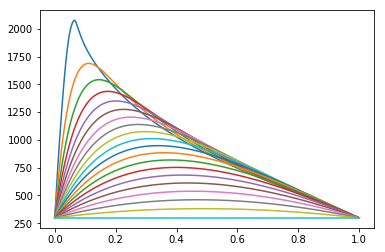

In [15]:
for i, nvar in enumerate(Z_variance):
    plt.plot(Z_average, flamelet_table[0,i,:,0])

In [45]:
# save the flamelet table
with h5py.File('flameletTable.h5', 'w') as f:
    
    f['flameletTable'] = flamelet_table
    
    # strings
    dt = h5py.special_dtype(vlen=str)
    ds = f.create_dataset('variable', variable_names.shape, dtype=dt)
    ds[...] = variable_names
    
    f['mixtureFractionAverage'] = Z_average
    f['mixtureFractionNormalizedVariance'] = Z_variance
    f['stoichiometricScalarDissipationRate'] = chi
    
    f['flameletTable'].dims.create_scale(f['variable'],
                                         'variable')
    
    f['flameletTable'].dims.create_scale(f['mixtureFractionAverage'],
                                         'mixtureFractionAverage')
    
    f['flameletTable'].dims.create_scale(f['mixtureFractionNormalizedVariance'],
                                         'mixtureFractionNormalizedVariance')
    
    f['flameletTable'].dims.create_scale(f['stoichiometricScalarDissipationRate'],
                                         'stoichiometricScalarDissipationRate')
    
    f['flameletTable'].dims[0].attach_scale(f['stoichiometricScalarDissipationRate'])
    f['flameletTable'].dims[1].attach_scale(f['mixtureFractionNormalizedVariance'])
    f['flameletTable'].dims[2].attach_scale(f['mixtureFractionAverage'])
    f['flameletTable'].dims[3].attach_scale(f['variable'])